# Name Entity Recognition (NER) Dataset

Link: https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset

Dataset description:

This is a very clean dataset and is for anyone who wants to try his/her hand on the NER ( Named Entity recognition ) task of NLP.

Tags:

* ORGANIZATION - Georgia-Pacific Corp., WHO
* PERSON - Eddy Bonte, President Obama
* LOCATION - Murray River, Mount Everest
* DATE - June, 2008-06-29
* TIME - two fifty a m, 1:30 p.m.
* MONEY - 175 million Canadian Dollars, GBP 10.40
* PERCENT - twenty pct, 18.75 %
* FACILITY - Washington Monument, Stonehenge
* GPE - South East Asia, Midlothian

In [1]:
!pip install -qU transformers
!pip install -qU datasets
!pip install -qU seqeval
!pip install -qU tensorboard

In [2]:
import re
import os
import time
import json
from typing import List, Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn.functional import pad
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler,random_split
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
from datasets import load_metric
from transformers import AutoTokenizer, BertForTokenClassification
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [3]:
CYELGREENBG = '\033[43m'
CFUKSIABG = '\033[45m'
CLBLUEBG = '\033[46m'
CGREYBG    = '\33[100m'
CREDBG    = '\33[101m'
CGREENBG  = '\33[102m'
CYELLOWBG = '\33[103m'
CBLUEBG   = '\33[104m'
CVIOLETBG = '\33[105m'
CBEIGEBG  = '\33[106m'
CEND  = '\33[107m'

color_mapping = {'O': CEND, 'GEO': CYELLOWBG, 'GPE': CREDBG, 'PER': CBLUEBG, 'ORG':CVIOLETBG,
                 'TIM': CBEIGEBG, 'ART': CYELGREENBG, 'NAT': CFUKSIABG, 'EVE':CLBLUEBG
                 }

## Data preprocessing

In [4]:
df = pd.read_csv("dataset.csv", encoding='unicode_escape').rename(columns={"Sentence #": "Sentence"})
df["Tag"] = df["Tag"].apply(lambda x: x.upper())
df["TagGeneral"] = df["Tag"].apply(lambda x: x.split("-")[-1])
df["TagPos"] = df["Tag"].apply(lambda x: x.split("-")[0])
df["Word"].fillna("None", inplace=True)
df

,Sentence,Word,POS,Tag,TagGeneral,TagPos
0,Sentence: 1,Thousands,NNS,O,O,O
1,NaN,of,IN,O,O,O
2,NaN,demonstrators,NNS,O,O,O
3,NaN,have,VBP,O,O,O
4,NaN,marched,VBN,O,O,O
...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O
1048571,NaN,responded,VBD,O,O,O
1048572,NaN,to,TO,O,O,O
1048573,NaN,the,DT,O,O,O


In [5]:
tag_list = df["Tag"].unique()
tag_general_list = df["TagGeneral"].unique()

n_tags = len(tag_list)
n_tag_general = len(tag_general_list)

tags2ids = {tag: i for i, tag in enumerate(tag_list)}
ids2tags = {i: tag for i, tag in enumerate(tag_list)}

df["TagId"] = df["Tag"].map(tags2ids)
df

,Sentence,Word,POS,Tag,TagGeneral,TagPos,TagId
0,Sentence: 1,Thousands,NNS,O,O,O,0
1,NaN,of,IN,O,O,O,0
2,NaN,demonstrators,NNS,O,O,O,0
3,NaN,have,VBP,O,O,O,0
4,NaN,marched,VBN,O,O,O,0
...,...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O,0
1048571,NaN,responded,VBD,O,O,O,0
1048572,NaN,to,TO,O,O,O,0
1048573,NaN,the,DT,O,O,O,0


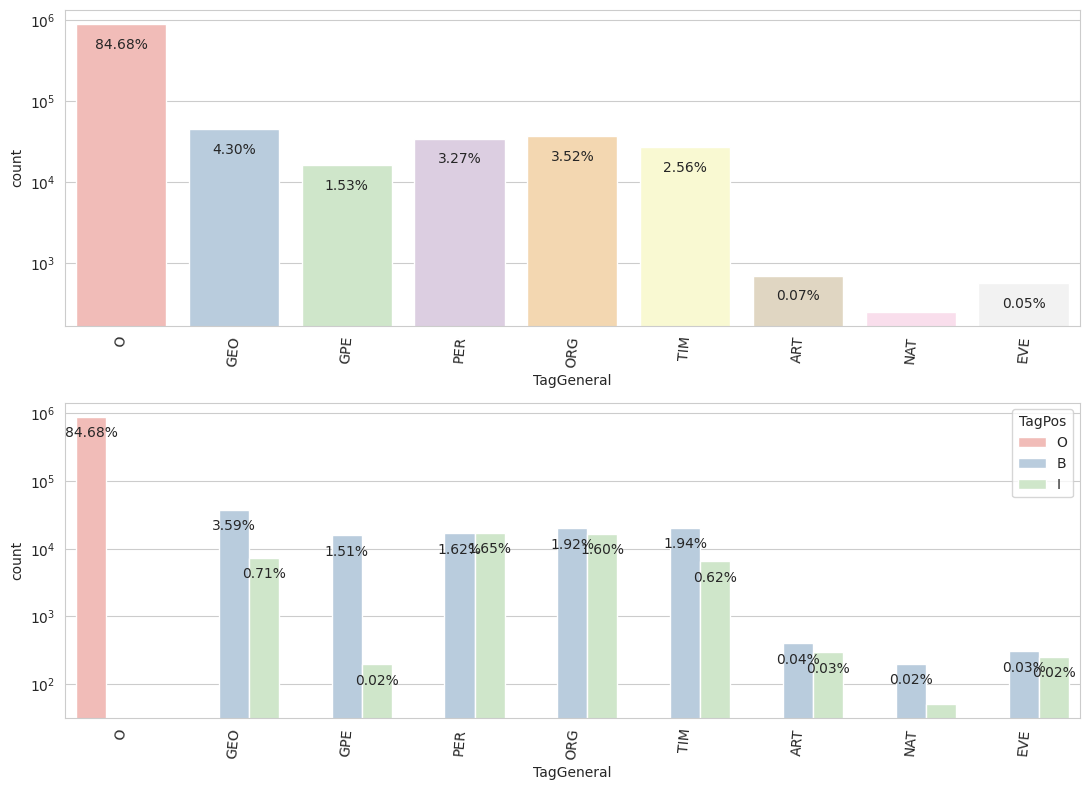

In [6]:
sns.set_palette(palette="Pastel1")
sns.set_style("whitegrid")

fig, axs =plt.subplots(2,1, figsize=(11,8))
sns.countplot(x=df['TagGeneral'], ax=axs[0])
sns.countplot(x=df['TagGeneral'], ax=axs[1], hue =df["TagPos"])
axs[0].tick_params(axis='x', rotation=85)
axs[1].tick_params(axis='x', rotation=85)

total = len(df)
for ax in axs:
  ax.set_yscale("log")
  for p in ax.patches:
      percentage = '{:.2f}%'.format(100 * p.get_height()/total)
      x = p.get_x() + p.get_width()/2
      y = p.get_height()/2
      ax.annotate(percentage, (x, y), ha='center', fontsize=10, rotation=0)
fig.tight_layout()
fig.show()

In [7]:
df["Sentence"] = df["Sentence"].fillna(method='ffill')
df = df.groupby("Sentence").agg(list).reset_index().drop("Sentence", axis=1)
print(f"Number of records: {len(df)}")
df.head(5)

Number of records: 47959


,Word,POS,Tag,TagGeneral,TagPos,TagId
0,"[Thousands, of, demonstrators, have, marched, through, London, to, protest, the, war, in, Iraq, and, demand, the, withdrawal, of, British, troops, from, that, country, .]","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, NN, IN, NNP, CC, VB, DT, NN, IN, JJ, NNS, IN, DT, NN, .]","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GPE, O, O, O, O, O]","[O, O, O, O, O, O, GEO, O, O, O, O, O, GEO, O, O, O, O, O, GPE, O, O, O, O, O]","[O, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]"
1,"[Iranian, officials, say, they, expect, to, get, access, to, sealed, sensitive, parts, of, the, plant, Wednesday, ,, after, an, IAEA, surveillance, system, begins, functioning, .]","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, JJ, NNS, IN, DT, NN, NNP, ,, IN, DT, NNP, NN, NN, VBZ, VBG, .]","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TIM, O, O, O, B-ORG, O, O, O, O, O]","[GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, TIM, O, O, O, ORG, O, O, O, O, O]","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, B, O, O, O, O, O]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 0, 0]"
2,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, NN, ,, WRB, JJ, NNP, NNS, VBP, VBN, TO, VB, VBN, TO, VB, DT, JJR, JJ, NN, IN, JJ, NNP, NNP, .]","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO, O]","[O, O, TIM, O, O, O, O, O, GEO, O, O, O, O, O, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, GEO, O]","[O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, O]","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0]"
3,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, JJ, CC, JJ, JJ, NNS, VBP, VBG, RP, NN, CC, NNS, TO, VB, NNS, IN, JJ, NNP, NN, IN, NN, NNS, MD, RB, VB, .]","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO, O, B-GPE, O, B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O, O, O, O, O, O, O]","[GEO, O, O, PER, PER, O, TIM, O, GEO, O, GPE, O, GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, O, O, O, O, O, O, O, O]","[B, O, O, B, I, O, B, O, B, O, B, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, O, O]","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


# Show example data with entities named

In [8]:
def display_formatted_text(words, tags):
    formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + CEND
    print(formatted_text)

In [9]:
text = df.loc[0, "Word"]
tags = df.loc[0, "TagGeneral"]
display_formatted_text(text, tags)

text = df.loc[42, "Word"]
tags = df.loc[42, "TagGeneral"]
display_formatted_text(text, tags)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
The U.S. rap star Snoop Dogg and five of his associates have been arrested in Britain after a disturbance at London 's Heathrow Airport .


# Tokenizer

In [10]:
model_name_or_path = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

## Dataset & Dataloaders

In [11]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["Word"].values
        self.labels =df["TagId"].values
        self.len = len(self.labels)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 is_split_into_words=True,
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )

        token_labels = self.__create_token_labels(self.labels[idx], encoded_dict.word_ids())
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], token_labels

    def __create_token_labels(self, labels, word_ids ):
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

    def __len__(self):
        return self.len

In [12]:
def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])

    ids = []
    token_types = []
    attention_masks = []
    labels = []

    for sample in batch:
        pad_length = max_len - len(sample[0])
        ids.append(pad(sample[0], (0, pad_length), value=0))
        token_types.append(pad(sample[1], (0, pad_length), value=0))
        attention_masks.append(pad(sample[2], (0, pad_length), value=0))
        labels.append(pad(sample[3], (0, pad_length), value=-100))
    return torch.stack(ids), torch.stack(token_types), torch.stack(attention_masks), torch.stack(labels)

In [13]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

38,367 training samples
9,592 validation samples


In [14]:
batch_size = 8

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

# Model

In [15]:
class NerModel(LightningModule):

    def __init__(
        self,
        model_name_or_path: str,
        n_tags: int,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.larning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
       
        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.model = BertForTokenClassification.from_pretrained(model_name_or_path, 
                                                                num_labels = n_tags, 
                                                                output_attentions = False,
                                                                output_hidden_states = False)
    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx):
        outputs = self.model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        return outputs.loss


    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:

        outputs = self.model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        
        predictions = torch.argmax(outputs.logits, axis=2)
        labels = batch[3]
        self.validation_step_outputs.append({"loss": outputs.loss, "predictions": predictions, "labels": batch[3]})
     

    def on_validation_epoch_end(self):

        outputs = self.validation_step_outputs

        predictions = np.hstack([x["predictions"] for x in outputs]).flatten()
        labels = np.hstack([x["labels"] for x in outputs]).flatten()
        loss = torch.stack([x["loss"] for x in outputs]).mean()

        all_predictions = []
        all_labels = []
        
        for pred_idx, label_idx in zip(predictions, labels):
            if label_idx != -100:
                all_predictions.append(ids2tags[pred_idx])
                all_labels.append(ids2tags[label_idx])

        metric = load_metric("seqeval")
        result = metric.compute(predictions=[all_predictions], references=[all_labels])
        print(result)
        
        self.log("validation_loss", loss, prog_bar=True)
        self.log("validation_accuracy", result["overall_accuracy"], prog_bar=True)
        self.log("validation_f1", result["overall_f1"], prog_bar=True)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.larning_rate, eps=self.adam_epsilon)
        return [optimizer]

    def save_model(self, savefile, ids2tags, tags2ids):
        model.model.save_pretrained(savefile)
        config = json.load(open(os.path.join(savefile, "config.json")))
        config["id2label"] = ids2tags
        config["label2id"] = tags2ids
        json.dump(config, open(os.path.join(savefile, "config.json"), "w"))

# Finding the best learning rate

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'ART': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'EVE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 12}, 'GEO': {'precision': 0.03773584905660377, 'recall': 0.0011730205278592375, 'f1': 0.0022753128555176336, 'number': 1705}, 'GPE': {'precision': 0.008821058527023242, 'recall': 0.07797029702970297, 'f1': 0.015849056603773583, 'number': 808}, 'NAT': {'precision': 0.0006090133982947625, 'recall': 0.4, 'f1': 0.0012161751292186075, 'number': 5}, 'ORG': {'precision': 0.019367028814359942, 'recall': 0.05401844532279315, 'f1': 0.028511821974965226, 'number': 759}, 'PER': {'precision': 0.018962962962962963, 'recall': 0.1128747795414462, 'f1': 0.032470826991374935, 'number': 567}, 'TIM': {'precision': 0.017964071856287425, 'recall': 0.008595988538681949, 'f1': 0.011627906976744186, 'number': 698}, 'overall_precision': 0.009220409220409221, 'overall_recall': 0.03903508771929825, 'overall_f1': 0.014917242824219568, 'overall_accuracy': 0.06379549626180776}


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 1.3046847980113467e-05
Restoring states from the checkpoint path at /home/neofelia/Desktop/kaggle/Named entity recognition/.lr_find_501703ba-c132-496c-9756-a33856e29a12.ckpt
Restored all states from the checkpoint at /home/neofelia/Desktop/kaggle/Named entity recognition/.lr_find_501703ba-c132-496c-9756-a33856e29a12.ckpt


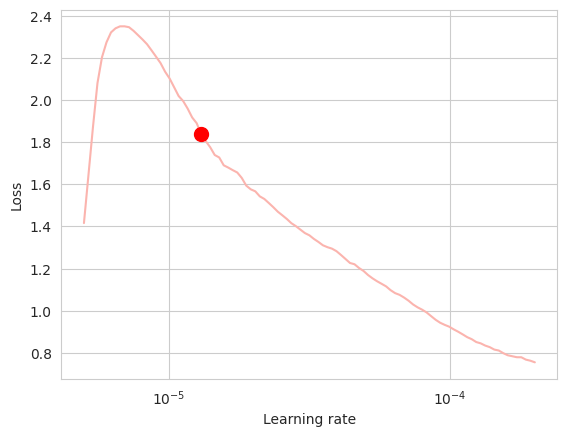

In [18]:
from pytorch_lightning.tuner import Tuner

epochs = 2
learning_rate = 1e-5
adam_epsilon = 1e-7

model = NerModel(model_name_or_path, n_tags, learning_rate, adam_epsilon)
trainer = Trainer(accelerator="cpu", max_epochs=epochs)

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, 
                          attr_name="larning_rate",
                          train_dataloaders=train_dataloader,
                          val_dataloaders=validation_dataloader,
                          min_lr=5e-6,
                          max_lr=2e-4,
                          early_stop_threshold=None
                        )

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Training

In [19]:
from lightning.pytorch.loggers import TensorBoardLogger

epochs = 2
learning_rate = 2e-5
adam_epsilon = 1e-7

early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=1)
logger = TensorBoardLogger("tb_logs", name="ner_model")

model = NerModel(model_name_or_path, n_tags, learning_rate, adam_epsilon)
trainer = Trainer(accelerator="cpu", max_epochs=epochs, callbacks=[early_stopping], logger=logger)
trainer.fit(model, train_dataloader, validation_dataloader)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | BertForTokenClassification | 107 M 
-----------------------------------------------------
107 M     Trainable params
0         Non-trainable params
107 M     Total params
430.931   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

{'ART': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'EVE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'GEO': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 45}, 'GPE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 16}, 'NAT': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 16}, 'PER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'TIM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 9}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.2156448202959831}


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'ART': {'precision': 0.30952380952380953, 'recall': 0.06914893617021277, 'f1': 0.11304347826086956, 'number': 188}, 'EVE': {'precision': 0.6296296296296297, 'recall': 0.13076923076923078, 'f1': 0.21656050955414013, 'number': 130}, 'GEO': {'precision': 0.8278513645657392, 'recall': 0.9116049141011209, 'f1': 0.8677118032099513, 'number': 20431}, 'GPE': {'precision': 0.958139534883721, 'recall': 0.9443765281173594, 'f1': 0.9512082499615208, 'number': 9816}, 'NAT': {'precision': 0.2903225806451613, 'recall': 0.14754098360655737, 'f1': 0.1956521739130435, 'number': 61}, 'ORG': {'precision': 0.7432002314814815, 'recall': 0.5568563685636856, 'f1': 0.6366734832992502, 'number': 9225}, 'PER': {'precision': 0.7837944145797824, 'recall': 0.7928381962864721, 'f1': 0.7882903672446759, 'number': 7540}, 'TIM': {'precision': 0.9188067444876783, 'recall': 0.853185595567867, 'f1': 0.8847811153437831, 'number': 8303}, 'overall_precision': 0.8461355049337882, 'overall_recall': 0.8283298021330844, 'overal

Validation: 0it [00:00, ?it/s]

{'ART': {'precision': 0.25925925925925924, 'recall': 0.11170212765957446, 'f1': 0.1561338289962825, 'number': 188}, 'EVE': {'precision': 0.5079365079365079, 'recall': 0.24615384615384617, 'f1': 0.3316062176165803, 'number': 130}, 'GEO': {'precision': 0.8250620887978737, 'recall': 0.9268268807204738, 'f1': 0.8729887971969942, 'number': 20431}, 'GPE': {'precision': 0.9695089895909998, 'recall': 0.9393846780766096, 'f1': 0.9542091374760697, 'number': 9816}, 'NAT': {'precision': 0.40476190476190477, 'recall': 0.2786885245901639, 'f1': 0.33009708737864074, 'number': 61}, 'ORG': {'precision': 0.6999149556554489, 'recall': 0.6244986449864499, 'f1': 0.6600595783684694, 'number': 9225}, 'PER': {'precision': 0.8158485273492286, 'recall': 0.7714854111405836, 'f1': 0.7930470347648262, 'number': 7540}, 'TIM': {'precision': 0.9003258115120067, 'recall': 0.8985908707696013, 'f1': 0.8994575045207956, 'number': 8303}, 'overall_precision': 0.8395978399886315, 'overall_recall': 0.8486731066183072, 'overa

`Trainer.fit` stopped: `max_epochs=2` reached.


# Evaluate

In [20]:
def evaluate(model, dataloader):

    metric = load_metric("seqeval")

    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        loop = tqdm(dataloader)
        for batch in loop:
            b_input_ids = batch[0]
            b_input_token_type = batch[1]
            b_input_mask = batch[2]
            b_labels = batch[3]

            output = model(input_ids=b_input_ids,
                          token_type_ids=b_input_token_type,
                          attention_mask=b_input_mask,
                          labels=b_labels)

            labels = b_labels.to('cpu').numpy()
            predictions = torch.argmax(output.logits.detach().cpu(), 2).numpy()

            for prediction, label in zip(predictions, labels):
                for pred_idx, label_idx in zip(prediction, label):
                    if label_idx != -100:
                        all_predictions.append(ids2tags[pred_idx])
                        all_labels.append(ids2tags[label_idx])

    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [21]:
evaluate(model, train_dataloader)

  0%|          | 0/4796 [00:00<?, ?it/s]

{'ART': {'precision': 0.7276595744680852,
  'recall': 0.44357976653696496,
  'f1': 0.5511684125705076,
  'number': 771},
 'EVE': {'precision': 0.5668016194331984,
  'recall': 0.3553299492385787,
  'f1': 0.436817472698908,
  'number': 394},
 'GEO': {'precision': 0.8712788444601022,
  'recall': 0.9579722074274923,
  'f1': 0.9125712045386408,
  'number': 82612},
 'GPE': {'precision': 0.9799153186407557,
  'recall': 0.9433281948109633,
  'f1': 0.9612737462891223,
  'number': 38273},
 'NAT': {'precision': 0.7226277372262774,
  'recall': 0.4351648351648352,
  'f1': 0.54320987654321,
  'number': 455},
 'ORG': {'precision': 0.8253688212927757,
  'recall': 0.7416295405471889,
  'f1': 0.7812616970429875,
  'number': 36587},
 'PER': {'precision': 0.8997501350621285,
  'recall': 0.8527585765488991,
  'f1': 0.8756243427970557,
  'number': 31248},
 'TIM': {'precision': 0.9347757103706908,
  'recall': 0.9373445183685276,
  'f1': 0.9360583519896006,
  'number': 34570},
 'overall_precision': 0.89498855

In [22]:
evaluate(model, validation_dataloader)

  0%|          | 0/1199 [00:00<?, ?it/s]

{'ART': {'precision': 0.25925925925925924,
  'recall': 0.11170212765957446,
  'f1': 0.1561338289962825,
  'number': 188},
 'EVE': {'precision': 0.5079365079365079,
  'recall': 0.24615384615384617,
  'f1': 0.3316062176165803,
  'number': 130},
 'GEO': {'precision': 0.8250620887978737,
  'recall': 0.9268268807204738,
  'f1': 0.8729887971969942,
  'number': 20431},
 'GPE': {'precision': 0.9695089895909998,
  'recall': 0.9393846780766096,
  'f1': 0.9542091374760697,
  'number': 9816},
 'NAT': {'precision': 0.40476190476190477,
  'recall': 0.2786885245901639,
  'f1': 0.33009708737864074,
  'number': 61},
 'ORG': {'precision': 0.6999149556554489,
  'recall': 0.6244986449864499,
  'f1': 0.6600595783684694,
  'number': 9225},
 'PER': {'precision': 0.8158485273492286,
  'recall': 0.7714854111405836,
  'f1': 0.7930470347648262,
  'number': 7540},
 'TIM': {'precision': 0.9003258115120067,
  'recall': 0.8985908707696013,
  'f1': 0.8994575045207956,
  'number': 8303},
 'overall_precision': 0.839597

# Save model

In [28]:
model.save_model("ner_model_2", ids2tags, tags2ids)
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Predict tags using hand-made function

In [23]:
from collections import Counter
import torch.nn.functional as F

def get_predicted_tag(word, tags, scores):
    most_common_tag = Counter(tags).most_common()[0][0]
    correct_scores = [score if tag == most_common_tag else -score for score, tag in zip(scores, tags)]
    score = round(sum(correct_scores)/len(correct_scores), 4)
    predicted_tag = ids2tags[most_common_tag].split("-")[-1]
    return {"word": word, "entity_group": predicted_tag, "score": score}


def predict(raw_text, display_formatted_text = True):

    raw_words = raw_text.split()
    encoded_dict = tokenizer(raw_words,
                             is_split_into_words=True,
                             add_special_tokens = True,
                             return_attention_mask = True,
                             return_tensors = 'pt'
                   )

    input_ids = encoded_dict['input_ids'][0].unsqueeze(0).to(device)
    input_token_type = encoded_dict['token_type_ids'][0].unsqueeze(0).to(device)
    input_mask = encoded_dict['attention_mask'][0].unsqueeze(0).to(device)

    output = model(input_ids = input_ids, token_type_ids=input_token_type, attention_mask=input_mask)
    normalized_output = F.softmax(output.logits.detach().cpu(), dim=2)
    predictions = torch.max(normalized_output, 2)
    predicted_label = predictions.indices.numpy().flatten()
    predicted_scores = predictions.values.numpy().flatten()

    result = []
    prev_token_id = None

    for token_id, predicted_label, score in zip(encoded_dict.word_ids(), predicted_label, predicted_scores):
        if token_id is None:
            continue
        elif token_id != prev_token_id:
            if prev_token_id is not None:
                result.append(get_predicted_tag(raw_words[prev_token_id],tags, scores))
            tags = []
            scores = []

        tags.append(predicted_label)
        scores.append(score)
        prev_token_id = token_id

    result.append(get_predicted_tag(raw_words[prev_token_id],tags, scores))

    if display_formatted_text:
        formatted_text = " ".join([color_mapping[entity["entity_group"]] + entity["word"] for entity in result]) + CEND
        print(formatted_text)
    
    return result

In [24]:
text = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
predict(text)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.


[{'word': 'Thousands', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'of', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'demonstrators', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'have', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'marched', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'through', 'entity_group': 'O', 'score': 0.9995},
 {'word': 'London', 'entity_group': 'GEO', 'score': 0.9966},
 {'word': 'to', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'protest', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'war', 'entity_group': 'O', 'score': 0.9993},
 {'word': 'in', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'Iraq', 'entity_group': 'GEO', 'score': 0.9976},
 {'word': 'and', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'demand', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'withdrawal', 'entity_group': 'O', 'score': 0.9999},
 {'w

In [25]:
example = input()
predict(example)
#This is a test from Krakow, Poland at 18:04 on Saturday Night


 This is a test from Krakow, Poland at 18:04 on Saturday Night


This is a test from Krakow, Poland at 18:04 on Saturday Night


[{'word': 'This', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'is', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'a', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'test', 'entity_group': 'O', 'score': 0.9995},
 {'word': 'from', 'entity_group': 'O', 'score': 0.9985},
 {'word': 'Krakow,', 'entity_group': 'GEO', 'score': 0.4772},
 {'word': 'Poland', 'entity_group': 'GEO', 'score': 0.9721},
 {'word': 'at', 'entity_group': 'O', 'score': 0.9857},
 {'word': '18:04', 'entity_group': 'O', 'score': 0.3455},
 {'word': 'on', 'entity_group': 'O', 'score': 0.9981},
 {'word': 'Saturday', 'entity_group': 'TIM', 'score': 0.9961},
 {'word': 'Night', 'entity_group': 'TIM', 'score': 0.9798}]

# Predict tags using transformers pipeline

In [26]:
from transformers import pipeline, AutoModelForTokenClassification

model_fine_tuned = AutoModelForTokenClassification.from_pretrained("ner_model")
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer, aggregation_strategy="first")

example = input()
ner_results = nlp(example)
print(ner_results)

 This is a test from Krakow, Poland at 18:04 on Saturday Night


[{'entity_group': 'GEO', 'score': 0.9772964, 'word': 'krakow', 'start': 20, 'end': 26}, {'entity_group': 'GEO', 'score': 0.86852366, 'word': 'poland', 'start': 28, 'end': 34}, {'entity_group': 'TIM', 'score': 0.7215245, 'word': '18', 'start': 38, 'end': 40}, {'entity_group': 'TIM', 'score': 0.81191814, 'word': 'saturday night', 'start': 47, 'end': 61}]
